# The Kinase Library

In [1]:
import os

import kinase_library as kl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## MEA - Motif Enrichment Analysis

**Kinase enrichment analysis based on Gene Set Enrichment Analysis (GSEA) algorithm for ranked differentially phosphorylated phosphosites.**

MEA compares the prediction distribution of each kinase across a ranked list of phosphosites.

> For the permutation analysis we use the python package `gseapy` ([Fang et al., Bioinformatics, 2022](https://academic.oup.com/bioinformatics/article/39/1/btac757/6847088))<br>
> Details about the GSEA process can be found in [Subramanian et al., PNAS, 2005](https://www.pnas.org/doi/abs/10.1073/pnas.0506580102)

#### Algorithm overview

<br>![Motif Enrichment Analysis](./images/mea.png "Motif Enrichment Analysis Workflow")<br>

Brief overview of the MEA process:
1. The **phosphoproteomics data is ranked**, based on a metric (e.g. logFC, -sign(logFC)*log10(p-value), or any other relevant metric).
2. The **Kinase Library predictions are applied** for each site in the data.
3. **Prediction threshold is determined** based on metric (score, percentile, score-rank, or percentile-rank) and threshold (see below for more details).
4. **Motif sets are created**: based on the prediction threshold above, each kinase motif is associated with a list of predicted phosphosites from the data. Paralleling MEA with GSEA - **_motifs are the pathways_** and **_phosphosites are the genes_**.
5. **Activity of kinases is derived using the GSEA workflow**. Specifically, for each kinase motif, the algorithm performs the following steps:<br>
    a. Traverses the ranked list of phosphosites and **calculates a running enrichment score** by increasing it when encountering a phosphosite that belongs to the motif and decreasing it when encountering one that does not.<br>
    > The ES is defined as the maximum deviation from zero observed in this running score.<br>
    This score reflects the extent to which the motif is enriched at the top (or bottom) of the ranked phosphosite list, indicating potential kinase activity.<br>
    The ES is normalized (NES) to account for differences in motif size, ensuring fair comparisons across kinases.<br>

    b. **Statistical significance** and false discovery rate (FDR) estimation.<br>
    > A null distribution of ES scores is generated for each kinase motif by permuting the ranked phosphosite list multiple times.
    The observed ES is compared to the null distribution to calculate a nominal p-value.
    To control for multiple testing, the p-values are adjusted to estimate the FDR.

    c. Final kinase activity inference: **kinases with significant NES** (based on a predefined FDR threshold) **are considered regulated** (positive NES for activated kinases, negative NES for inhibited kinases).
    > The NES values provide a quantitative measure of activity, which can be used for downstream analyses, such as pathway enrichment or clustering.

This process allows the MEA method to infer kinase activity from phosphoproteomics data in a statistically robust and biologically meaningful way, leveraging the predictive capabilities of the Kinase Library and the powerful enrichment framework of GSEA.

> _**Fisher's exact test vs MEA?**_<br>
> While the differential phosphorylation enrichment tool based on Fisher's Exact Test usually yields robust results for sufficiently large datasets with standard threshold parameters, MEA eliminates the need to define a threshold for differentially phosphorylated sites by leveraging rank-based analysis. This approach makes MEA particularly advantageous for small datasets, where traditional statistical significance thresholds in phosphoproteomics data might identify few or no regulated sites. However, in large datasets, MEA can sometimes yield inflated results, as the algorithm may flag minor changes as statistically significant due to the sheer number of sites analyzed. Therefore, it is up to the user to decide which method is most appropriate—or alternatively, to use both methods and interpret the results in tandem for a more comprehensive analysis.

#### Prediction parameters

In order to define a kinase as "predicted" for a certain substrate (and by that to have this substrate in its motif list), one can use different methods (score, percentile, rank) and different thresholds.

For example:
| Method | Threshold | Explanation |
| :---: | :---: | :---: |
| score | 1 | All kinases with score >1 |
| percentile | 90 | All kinases with percentile >90 |
| score_rank | 8 | Top-8 kinases based on score |
| percentile_rank | 15 | Top-8 kinases based on percentile |

Although different methods and thresholds might be used for different circumstances, we generally recommend the following methods and thresholds for the different kinase types:
> * **Ser/Thr: percentile-rank, 15**
> * **Tyrosine: percentile-rank, 8**

### Motif Enrichment Analysis

We will use quantitative phosphoproteomics data from _[Bekker-Jensen et al., Nature Communications (2020)](https://www.nature.com/articles/s41467-020-14609-1)_.

Reading the phosphoproteomics data for all the inhibitors:

In [2]:
all_inhibitors_data = pd.read_excel('./test_files/2020_bekker_jensen_inhibitors.xlsx', skiprows=3)

Creating a RankedPhosData object:

In [3]:
treatment = 'MEKi_Cobimetinib_0-1' #MEK inhibitor

ranked_phos = kl.RankedPhosData(dp_data=all_inhibitors_data, rank_col=treatment, seq_col='PTM_seq')

50 entries were omitted due to empty value in the substrates column.
2 entries were omitted due to even length (no central position).
4 entries were omitted due to invalid central phosphoacceptor.
Use the 'omited_entries' attribute to view dropped enteries due to invalid sequences.


Running kinase enrichment based on KL method and threshold:

In [4]:
ser_thr_mea_res = ranked_phos.mea(kin_type='ser_thr', kl_method='percentile_rank', kl_thresh=15)


Calculating percentiles for data
Scoring 1201 ser_thr substrates
Calculating percentile for 1201 ser_thr substrates


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:02<00:00, 112.51it/s]



Generating kinase-substartes sets


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 6715.79it/s]
2024-12-04 16:02:08,950 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2024-12-04 16:02:08,959 [WARNING] Duplicated values found in preranked stats: 7.52% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


### Enrichment results

Once the enrichment analysis was performed, enrichment results can be accessed as a table:
> 1. **_ES_**: The raw enrichment score calculated for each kinase motif. This score represents the degree of overrepresentation of motif-associated phosphosites at the top or bottom of the ranked list of phosphosites. Higher absolute values of ES indicate stronger enrichment.
> 2. **_NES_**: The normalized version of the enrichment score, adjusted for differences in motif sizes. This ensures comparability between motifs of different lengths or numbers of associated phosphosites. NES is often used to rank motifs and identify those with significant enrichment.
> 3. **_p-value_**: The nominal p-value for the enrichment score. It indicates the statistical significance of the observed ES compared to the null distribution of ES scores generated by random permutations of the ranked list. A lower p-value suggests stronger statistical significance.
> 4. **_FDR_**: The adjusted p-value controlling for multiple comparisons. The FDR estimates the proportion of false positives among all motifs declared significant. It helps to account for the large number of motifs tested in the analysis.
> 5. **_Subs fraction_**: The fraction of phosphosites (or "substrates") associated with the kinase motif that contributed to the enrichment analysis. The denominator is the number of substrates that passed the Kinase Library threshold and have a valid value in the ranked list (i.e., not NaN). This metric provides insight into the extent to which the motif's predicted sites are represented and enriched in the dataset. Higher fractions suggest broader motif coverage among the ranked phosphosites.
> 6. **_Leading substrates_**: The specific phosphosites (or substrates) that contribute most to the enrichment score. These are the top-ranked phosphosites in the dataset associated with the kinase motif, forming the "leading edge" subset that drives the enrichment result. This information helps identify the key sites underlying the kinase activity.

In [5]:
ser_thr_mea_res.enrichment_results.sort_values('NES')

,ES,NES,p-value,FDR,Subs fraction,Leading substrates
Kinase,,,,,,
RSK2,-0.736371,-1.830922,0.001000,0.000710,31/50,RVSIRLPsTSGSEGV;KIKPRLKsEDGVEGD;ATPSRKRsVAVSDE...
RSK4,-0.689658,-1.741591,0.001000,0.014546,32/60,RVSIRLPsTSGSEGV;KIKPRLKsEDGVEGD;ARRLGRGsVSDCSD...
ERK1,-0.645535,-1.719476,0.001000,0.014664,66/163,DSPGIPPsANAHQLF;PLSPPPLtPKATRTL;PPQSTPLsPPPLTP...
PKACB,-0.727041,-1.691564,0.001138,0.018803,16/27,AEVARRKsVPSETVV;RRPKHRPsEADEEEL;PHKRRKTsDANETE...
P38B,-0.634726,-1.684724,0.001000,0.017029,63/164,DSPGIPPsANAHQLF;PLSPPPLtPKATRTL;PPQSTPLsPPPLTP...
...,...,...,...,...,...,...
PDHK1,0.517216,1.892428,0.001000,0.025717,20/41,QARASWEsLDEEWRA;PRTKTVLsLFDEEED;LAKGVSMsLPSSPL...
NEK9,0.58257,1.922634,0.001000,0.027123,12/32,SPGPQARsFTGGLGQ;GSLASLDsLRKGGPP;FDPLSSGsRSSSLK...
MST2,0.574144,1.970101,0.001000,0.020091,20/36,PVPSPTGtISVPNSC;NFLEDNPsLKDIMLA;LQPDAYGsLDRATS...


### Plotting enrichment results

Finally, the enrichment results can be displayed using a volcano plot:

_**Note: for further design options of the volcano plot please refer to the plotting data page_

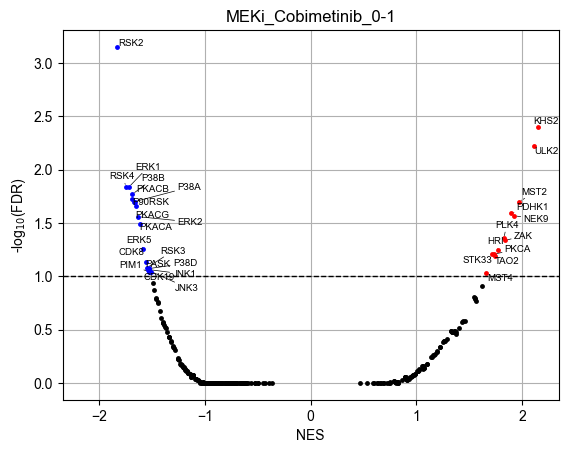

In [6]:
ser_thr_mea_res.plot_volcano(title=treatment, adj_pval=True, sig_pval=0.1)

As expected, the RSK kinases and ERK kinases are the most inhibited (i.e., their distribution is denser among sites ranked at the bottom of the list) following MEK inhibition with Cobimetinib.

### MEA for small datasets

One of the advantages of MEA is its effectiveness with small datasets, making it particularly useful for analyzing tyrosine phosphoproteomics, which typically has significantly fewer detected phosphosites.

In [7]:
treatment = 'EGFRi_Erlotinib_0-1' #EGFR inhibitor

ranked_phos = kl.RankedPhosData(dp_data=all_inhibitors_data, rank_col=treatment, seq_col='PTM_seq')

tyr_mea_res = ranked_phos.mea(kin_type='tyrosine', kl_method='percentile_rank', kl_thresh=8)

50 entries were omitted due to empty value in the substrates column.
2 entries were omitted due to even length (no central position).
4 entries were omitted due to invalid central phosphoacceptor.
Use the 'omited_entries' attribute to view dropped enteries due to invalid sequences.

Calculating percentiles for data
Scoring 18 tyrosine substrates
Calculating percentile for 18 tyrosine substrates


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 1769.71it/s]



Generating kinase-substartes sets


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 8368.87it/s]
2024-12-04 16:02:12,179 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2024-12-04 16:02:12,186 [WARNING] Duplicated values found in preranked stats: 7.31% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


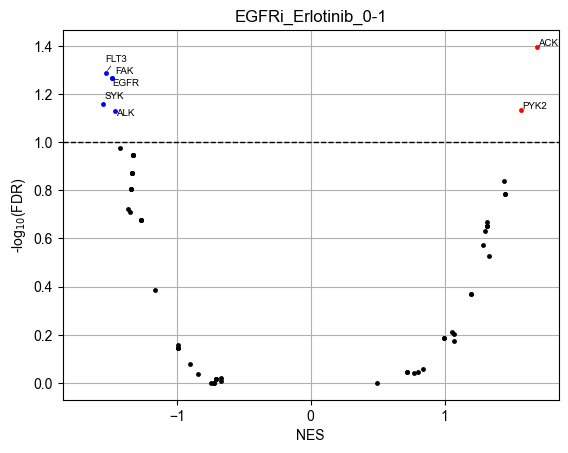

In [8]:
tyr_mea_res.plot_volcano(title=treatment, adj_pval=True, sig_pval=0.1)

> Note: similarly here, the user might want to use nominal p-value instead of FDR for very small datasets.

### Plotting multiple comparisons

In case of multiple comparisons (e.g. multiple time points, drugs etc), results can be plotted together as a bubblemap:

_**Note: for further design options of the bubblemap please refer to the plotting data page_

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5] #For Jupyter Notebook

# inhibitors = all_inhibitors_data.columns[:62]
inhibitors = ['MEKi_PD0325901_0-1', 'MEKi_PD0325901_1', 'MEKi_Cobimetinib_0-1', 'MEKi_Cobimetinib_1', 'MEKi_U0126_0-1', 'MEKi_U0126_1']

# Scoring data one time at the beginning
pps_data = kl.PhosphoProteomics(all_inhibitors_data, seq_col='PTM_seq')
ser_thr_percentiles = pps_data.percentile('ser_thr', values_only=True)

kin_type = 'ser_thr'
method = 'percentile_rank'
thresh = 15

kl_en_res = {}

for i,inh in enumerate(inhibitors):
    print(str(i) + ': ' + inh)
    ranked_phos = kl.RankedPhosData(dp_data=all_inhibitors_data, rank_col=inh, seq_col='PTM_seq')
    ranked_phos.submit_percentiles('ser_thr', ser_thr_percentiles, suppress_messages=True)
    
    mea_res = ranked_phos.mea(kin_type=kin_type, kl_method=method, kl_thresh=thresh)
    # ser_thr_en_res.plot_volcano(max_window=True, adj_pval=False)
    
    kl_en_res[inh] = mea_res

50 entries were omitted due to empty value in the substrates column.
2 entries were omitted due to even length (no central position).
4 entries were omitted due to invalid central phosphoacceptor.
Use the 'omited_entries' attribute to view dropped enteries due to invalid sequences.
Scoring 1201 ser_thr substrates
Calculating percentile for 1201 ser_thr substrates


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:02<00:00, 114.19it/s]


0: MEKi_PD0325901_0-1
50 entries were omitted due to empty value in the substrates column.
2 entries were omitted due to even length (no central position).
4 entries were omitted due to invalid central phosphoacceptor.
Use the 'omited_entries' attribute to view dropped enteries due to invalid sequences.

Generating kinase-substartes sets


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 6830.07it/s]
2024-12-04 16:02:16,406 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2024-12-04 16:02:16,411 [WARNING] Duplicated values found in preranked stats: 6.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


1: MEKi_PD0325901_1
50 entries were omitted due to empty value in the substrates column.
2 entries were omitted due to even length (no central position).
4 entries were omitted due to invalid central phosphoacceptor.
Use the 'omited_entries' attribute to view dropped enteries due to invalid sequences.

Generating kinase-substartes sets


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 6369.69it/s]
2024-12-04 16:02:17,497 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2024-12-04 16:02:17,503 [WARNING] Duplicated values found in preranked stats: 7.57% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


2: MEKi_Cobimetinib_0-1
50 entries were omitted due to empty value in the substrates column.
2 entries were omitted due to even length (no central position).
4 entries were omitted due to invalid central phosphoacceptor.
Use the 'omited_entries' attribute to view dropped enteries due to invalid sequences.

Generating kinase-substartes sets


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 7031.70it/s]
2024-12-04 16:02:18,551 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2024-12-04 16:02:18,555 [WARNING] Duplicated values found in preranked stats: 7.52% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


3: MEKi_Cobimetinib_1
50 entries were omitted due to empty value in the substrates column.
2 entries were omitted due to even length (no central position).
4 entries were omitted due to invalid central phosphoacceptor.
Use the 'omited_entries' attribute to view dropped enteries due to invalid sequences.

Generating kinase-substartes sets


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 6568.15it/s]
2024-12-04 16:02:19,623 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2024-12-04 16:02:19,628 [WARNING] Duplicated values found in preranked stats: 8.15% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


4: MEKi_U0126_0-1
50 entries were omitted due to empty value in the substrates column.
2 entries were omitted due to even length (no central position).
4 entries were omitted due to invalid central phosphoacceptor.
Use the 'omited_entries' attribute to view dropped enteries due to invalid sequences.

Generating kinase-substartes sets


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 6539.25it/s]
2024-12-04 16:02:20,663 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2024-12-04 16:02:20,668 [WARNING] Duplicated values found in preranked stats: 6.90% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


5: MEKi_U0126_1
50 entries were omitted due to empty value in the substrates column.
2 entries were omitted due to even length (no central position).
4 entries were omitted due to invalid central phosphoacceptor.
Use the 'omited_entries' attribute to view dropped enteries due to invalid sequences.

Generating kinase-substartes sets


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 6625.90it/s]
2024-12-04 16:02:21,717 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2024-12-04 16:02:21,722 [WARNING] Duplicated values found in preranked stats: 7.42% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/Users/tomer/opt/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


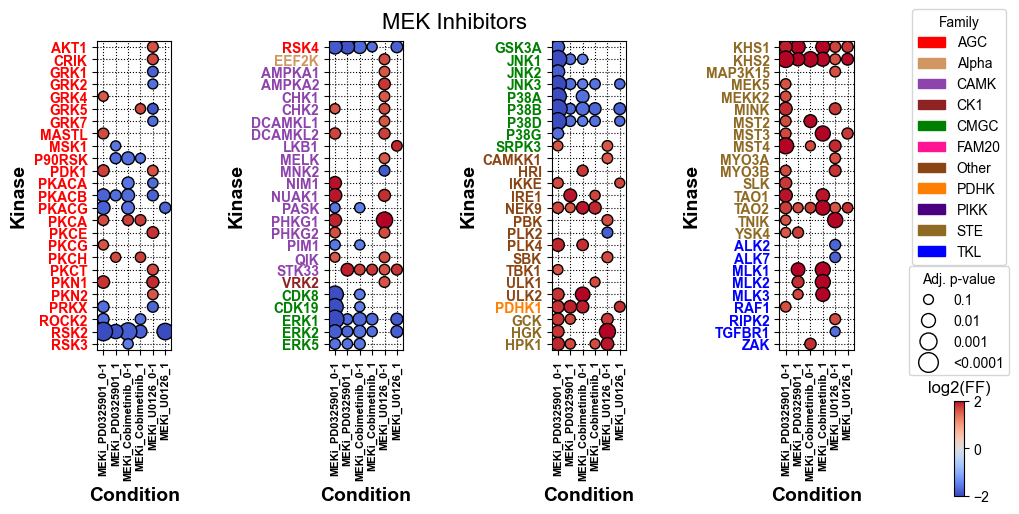

In [10]:
lff_data,pval_data = kl.combine_mea_enrichment_results(kl_en_res, adj_pval=True)
kl.plot_bubblemap(lff_data=lff_data, pval_data=pval_data, max_pval_size=None, num_panels=4, only_sig_kins=True, title='MEK Inhibitors', sig_pval=0.1, bubblesize_range=(50,200), max_window=False, constrained_layout=True)

As expected, we can see the dowsntream kinases of MEK - ERKs - getting inhibited, as well as additional kinases from the PI3K/AKT pathway (RSK2/4 and p90RSK).

### Downstream Substrates

Finally, analyzing the downstream substrates of each enriched kinase can provide further biological insights. In this context, the "enriched substrates" refer to those from the list that passed the Kinase Library threshold.

_**Note: use the `save_to_excel` flag to directly save the results_

In [11]:
ser_thr_mea_res.enriched_subs(kinases='RSK2')['RSK2']

,EGFRi_Erlotinib_1,EGFRi_AG1478_1,EGFRi_Lapatinib_0-1,EGFRi_AG1478_0-1,EGFRi_Lapatinib_1,NoSerum,MEKi_PD0325901_0-1,MEKi_Cobimetinib_0-1,MEKi_Cobimetinib_1,MEKi_PD0325901_1,...,PTM_0_num,PTM_group,PTM_collapse_key,PTM_collapse_key_num,PTM_seq,PhosphoSitePlus kinase uniprot,PhosphoSitePlus window,phos_res,Sequence,RSK2
Sequence,,,,,,,,,,,,,,,,,,,,,
RKVERKPsVSEEVQA,-0.890068,-0.822296,-0.783898,-0.829517,-0.898192,-0.652403,-0.278758,-1.086230,-0.654753,-1.362790,...,1,_KPS[Phospho (STY)]VSEEVQATPNK_.2;_KPS[Phospho...,GPATCH8_S1107_M1,4.0,LLLEKIQSRKVERKPSVSEEVQATPNKAGPK,NaN,RKVERKPsVsEEVQA,s,RKVERKPsVSEEVQA,1
APRLRKGsDALRPPV,-1.066820,-0.999825,-0.950871,-1.189960,-1.589980,-1.475810,0.427237,0.062303,0.000000,-0.899729,...,1,_GS[Phospho (STY)]DALRPPVPQGEDEVPK_.2;_GS[Phos...,EHBP1L1_S310_M1,3.0,AQDTAPTPAPRLRKGSDALRPPVPQGEDEVP,NaN,APRLRKGsDALRPPV,s,APRLRKGsDALRPPV,1
KKRVRRPsESDKEDE,0.636637,0.257912,-0.070320,-0.409014,0.601740,0.872974,-0.554821,0.131203,0.484034,0.683849,...,1,_RPS[Phospho (STY)]ESDKEDELDK_.2;_RPS[Phospho ...,AKAP12_S627_M1,2.0,SFKKMVTPKKRVRRPSESDKEDELDKVKSAT,P17612,KKRVRRPsEsDKEDE,s,KKRVRRPsESDKEDE,1
EPRERVPsVAEAPQL,-2.032160,-1.701840,-1.955520,-2.151320,-2.019090,-2.120770,-0.110033,-0.472410,-0.721567,-0.421965,...,1,_ERVPS[Phospho (STY)]VAEAPQLRPAGTAAAK_.3;_ERVP...,KANK2_S540_M1,6.0,DSTENEAPEPRERVPSVAEAPQLRPAGTAAA,NaN,EPRERVPsVAEAPQL,s,EPRERVPsVAEAPQL,1
RVRVRRAsISEPSDT,0.008477,0.080003,-0.043769,-0.014260,0.171910,0.337203,-0.000661,-0.187766,-0.294559,0.098798,...,1,_RAS[Phospho (STY)]ISEPSDTDPEPR_.2;_RAS[Phosph...,STK11IP_S398_M1,3.0,PLLHKVKSRVRVRRASISEPSDTDPEPRTLN,NaN,RVRVRRAsIsEPsDt,s,RVRVRRAsISEPSDT,2
VPKQRKLsASYEKEK,-0.387785,-0.369371,-0.028631,NaN,0.205442,-0.535079,NaN,-0.694575,NaN,-0.685319,...,1,_KLS[Phospho (STY)]ASYEK_.2,BTRC_S127_M1,1.0,ANGTSSMIVPKQRKLSASYEKEKELCVKYFE,NaN,VPKQRKLsASYEKEK,s,VPKQRKLsASYEKEK,2
PPVARKPsVGVPPPA,-1.542810,-0.032666,-1.568320,-2.170360,-1.417910,-1.133430,-0.846707,-1.008260,-0.803552,-0.583922,...,2,_KPS[Phospho (STY)]VGVPPPAS[Phospho (STY)]PSYP...,KIAA1522_S971_M2,2.0,PKKSPKAPPPVARKPSVGVPPPASPSYPRAE,NaN,PPVARKPsVGVPPPA,s,PPVARKPsVGVPPPA,3
KLRRRTFsLTEVRGQ,-2.206320,-1.566410,-1.812980,-2.232550,-1.672050,-2.259340,0.150612,-0.111552,-0.797920,-0.460853,...,1,_TFS[Phospho (STY)]LTEVR_.2,KIF4A_S801_M1,1.0,ESGENPPPKLRRRTFSLTEVRGQVSESEDSI,NaN,KLRRRtFsLTEVRGQ,s,KLRRRTFsLTEVRGQ,3
GRGRRRVsEVEEEKE,-0.566679,-0.454459,-0.817405,-0.925548,-0.788737,-0.967595,-0.690608,-0.315776,-0.527183,-0.741975,...,1,_RRVS[Phospho (STY)]EVEEEK_.2;_RVS[Phospho (ST...,SART1_S448_M1,3.0,GDFGSRLRGRGRRRVSEVEEEKEPVPQPLPS,NaN,GRGRRRVsEVEEEKE,s,GRGRRRVsEVEEEKE,3
